# T1
### Exercise 2

We want to get a grip on T1 signal curves as commonly observed in FLASH acquisition with variable flip angle.

**ToDo** Add Sequence diagram


In [9]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplc
from scipy.optimize import curve_fit
plt.style.use('ggplot')

### Signal of FLASH acquisisiton
#### $T_1$, $T_R$, $\alpha$
We want to take a look at the signal curve dependent on some parameters ($\alpha$ is the excitation flip angle)

The FLASH signal can be described by
$$ S(T_1, T_R, \alpha) = \frac{1 - e^{- T_R / T_1}}{1 - cos(\alpha) e^{-T_R / T_1}} sin(\alpha) $$

We define this first

In [2]:
def signal_flash(fa:float, t1_val:float, tr_val:float):
    # use timings in same order of magnitude (s, ms, us) and flip angle in °
    if t1_val < np.finfo(float).eps:
        err = "provide positive nonzero T1"
        raise ValueError(err)
    fa = np.radians(fa)
    signal = np.sin(fa) * (1 - np.exp(-tr_val / t1_val)) / (1 - np.cos(fa) * np.exp(-tr_val / t1_val))
    return signal

### T1
We plot some curves for different T1

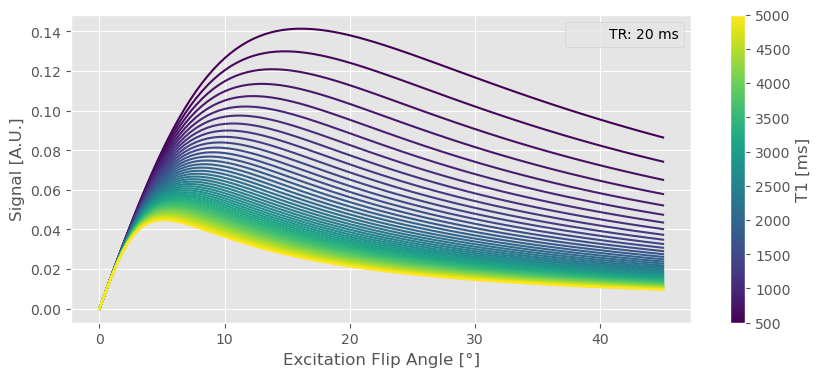

In [12]:
TR = 20
T1 = np.linspace(500, 5000, 50)      # [ms] for gray, white matter and CSF @ 3T ~ 900, 1600, 4000 ms
alpha = np.linspace(0, 45, 100)
color = cm.viridis(np.linspace(0,1,T1.shape[0]))
norm = mplc.Normalize(vmin=np.min(T1), vmax=np.max(T1))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()

for t1_idx in range(T1.shape[0]):
    ax.plot(alpha, signal_flash(alpha, T1[t1_idx], TR), color=color[t1_idx])
ax.set_xlabel("Excitation Flip Angle [°]")
ax.set_ylabel("Signal [A.U.]")
# add hacky TR descriptor
ax.plot([], [], ' ', label=f"TR: {TR} ms")
ax.legend()
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('viridis')), ax=ax, label=f"T1 [ms]")
plt.show()

### TR
We plot some curves for different TR

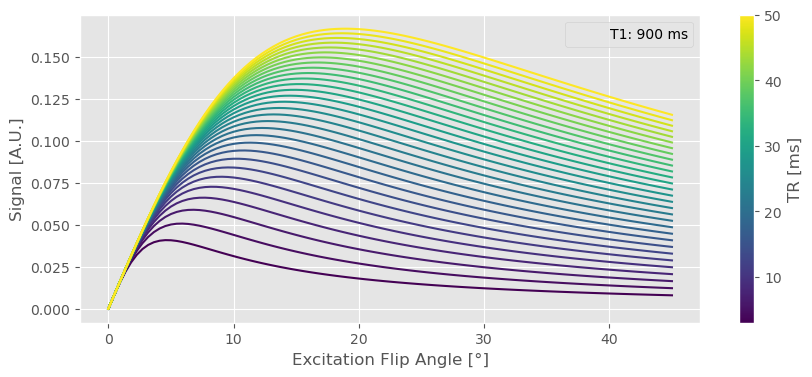

In [14]:
T1 = 900        # [ms]
TR = np.linspace(3,50,30)
alpha = np.linspace(0, 45, 100)
color = cm.viridis(np.linspace(0,1,TR.shape[0]))
norm = mplc.Normalize(vmin=np.min(TR), vmax=np.max(TR))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()

for tr_idx in range(TR.shape[0]):
    ax.plot(alpha, signal_flash(alpha, T1, TR[tr_idx]), color=color[tr_idx])
ax.set_xlabel("Excitation Flip Angle [°]")
ax.set_ylabel("Signal [A.U.]")
# add hacky T1 descriptor
ax.plot([], [], ' ', label=f"T1: {T1} ms")
ax.legend()
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('viridis')), ax=ax, label=f"TR [ms]")
plt.show()

### Fitting T1
We fix $T_R$ and use variable flip angles to get multiple datapoints to extract $T_1$

In [5]:
# lets create some data plus noise
T1 = [900, 1600, 4000]
TR = 20
SNR = 6
alpha_acquired = np.linspace(0, 45, 10)
# for visualization
alpha_vis = np.linspace(np.min(alpha_acquired), np.max(alpha_acquired), 200)

data = np.zeros([T1.__len__(), alpha_acquired.shape[0]])

for t1_idx in range(T1.__len__()):
    sig = signal_flash(alpha_acquired, T1[t1_idx], TR)
    data[t1_idx] = sig + (np.random.random(size=sig.shape[0]) -0.5) * np.max(sig) / SNR

In [6]:
# fit
fit_t1 = np.zeros([T1.__len__(), 2])
for t1_idx in range(T1.__len__()):
    # we choose some sane starting conditions and bounds - [(FA,) T1, TR], knowing TR from the measurement
    fit_params = curve_fit(signal_flash, alpha_acquired, data[t1_idx], p0=[1500, TR], bounds=([1.0, 0.9*TR], [10000, 1.1*TR]))
    # only interested in the estimates
    fit_t1[t1_idx] = fit_params[0]

In [18]:
# we define a helper function for the linearized plotting to make sure we dont divide by 0
def linearizing_division(signal: float, fa:float):
    # get signal values as float, and fa in °
    eps = np.finfo(float).eps
    y_ax = np.divide(
        signal, np.sin(np.radians(fa)),
        where=np.sin(np.radians(fa))>eps,
        out=np.zeros_like(signal)
    )
    x_ax = np.divide(
        signal,
        np.tan(np.radians(fa)),
        where=np.tan(np.radians(fa))>eps,
        out=np.zeros_like(signal)
    )
    return x_ax[y_ax>eps], y_ax[y_ax>eps]

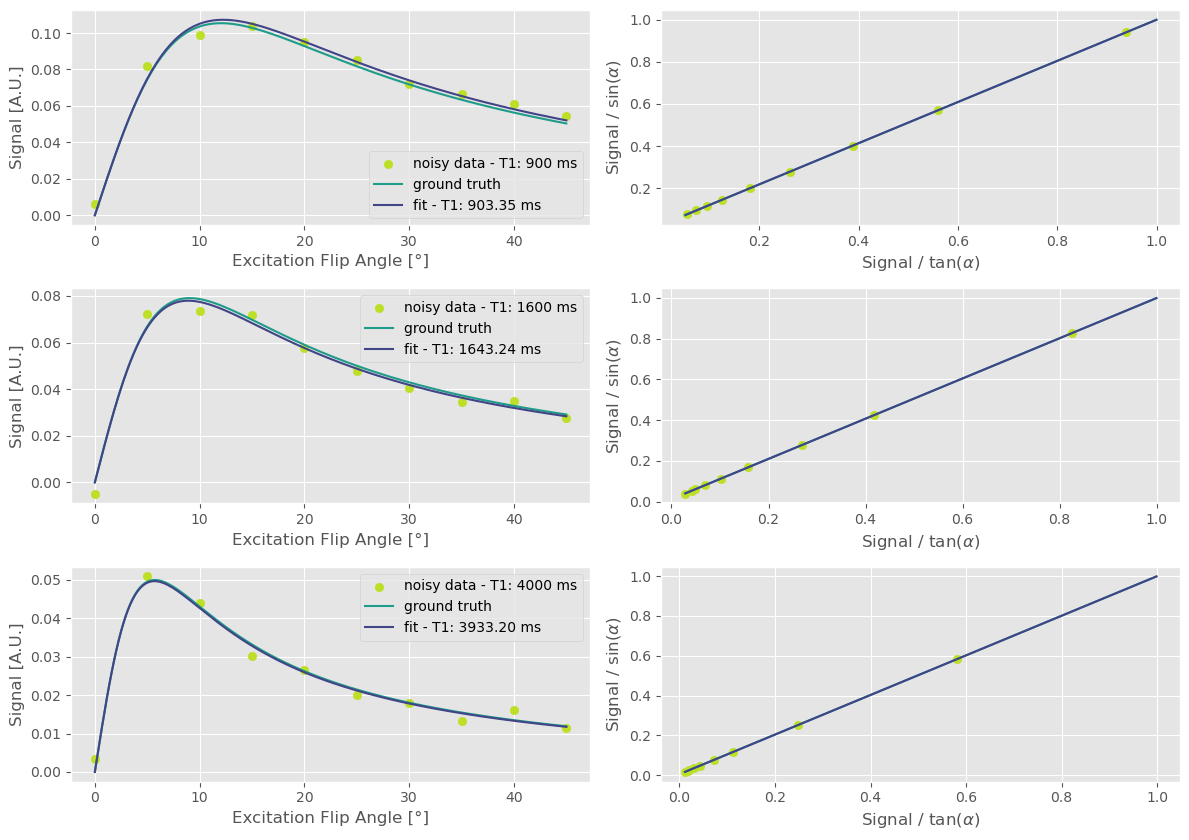

In [20]:
fig = plt.figure(figsize=(12, 8.5))

for t1_idx in range(T1.__len__()):
    # plot fit
    color = cm.viridis(np.linspace(0.9,0.2,3))
    ax = fig.add_subplot(T1.__len__(), 2, 2*t1_idx+1)

    ax.scatter(alpha_acquired, data[t1_idx], color=color[0], label=f'noisy data - T1: {T1[t1_idx]} ms')
    ax.plot(alpha_vis, signal_flash(alpha_vis, T1[t1_idx], TR), color=color[1], label='ground truth')
    ax.plot(alpha_vis, signal_flash(alpha_vis, *fit_t1[t1_idx]), color=color[2], label=f"fit - T1: {fit_t1[t1_idx][0]:.2f} ms")

    ax.legend()
    ax.set_xlabel("Excitation Flip Angle [°]")
    ax.set_ylabel("Signal [A.U.]")

    # plot linearized version for different visualization
    ax = fig.add_subplot(T1.__len__(), 2, 2*t1_idx+2)
    ax.scatter(*linearizing_division(data[t1_idx], alpha_acquired), color=color[0], label=f'noisy data - T1: {T1[t1_idx]} ms')
    ax.plot(*linearizing_division(signal_flash(alpha_vis, T1[t1_idx], TR), alpha_vis), color=color[1], label='ground truth')
    ax.plot(*linearizing_division(signal_flash(alpha_vis, *fit_t1[t1_idx]), alpha_vis), color=color[2], label=f"fit - T1: {fit_t1[t1_idx][0]:.2f} ms")

    ax.set_xlabel("Signal / tan($\\alpha$)")
    ax.set_ylabel("Signal / sin($\\alpha$)")
plt.tight_layout()
plt.show()